<a href="https://colab.research.google.com/github/niroojen-thambimuthu/SAIT-475/blob/master/language_model_Runtime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from fastai.text import *

path = "/content/drive/My Drive/DATA-475/imdb"

In [3]:
# create TextLMDataBunch using the csv in path
#     remember to specify the text column
data_lm = TextLMDataBunch.from_csv(
    path,
    "train.csv",
    text_cols="review"
)

In [4]:
# create TextClasDataBunch using the csv in path
#     remember to specify the text/label column
#     specify test dataset, vocab, and bs
data_clas = TextClasDataBunch.from_csv(
    path,
    "train.csv",
    test="test.csv",
    text_cols="review",
    label_cols="sentiment",
    vocab=data_lm.train_ds.vocab,
    bs=32
)

In [5]:
# create language model learner with AWD_LSTM architecture and drop_mult of 0.5
lm_learner = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.5)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 3.98E-03


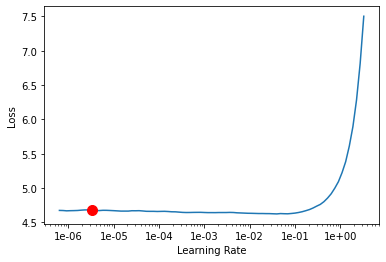

In [6]:
# find a learing rate
lm_learner.lr_find()
lm_learner.recorder.plot(suggestion=True)

In [7]:
# fit one cycle
lr = lm_learner.recorder.min_grad_lr
lm_learner.fit_one_cycle(2,lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.705176,4.474645,0.263893,04:22
1,4.669322,4.468564,0.264349,04:22


In [8]:
# save the encoder
lm_learner.save_encoder("model")

In [9]:
lm_learner.predict("this movie talks about Canadian", n_words=20)

"this movie talks about Canadian morality , is referred to as Roger Database style by the ABC 's Norse Constabulary"

In [10]:
clas_learner = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5)
clas_learner.load_encoder("model")

RNNLearner(data=TextClasDataBunch;

Train: LabelList (19999 items)
x: TextList
xxbos xxmaj this movie is a ripoff of xxmaj james xxmaj cain 's novel , xxup the xxup postman xxup always xxup rings xxup twice . xxmaj apparently , the director and producer never bothered to pay for rights to this story -- perhaps the fact that we were in the middle of fighting the xxmaj italians in xxup wwii might account for their forgetting to consider royalties ! xxmaj despite this , the movie is n't really just an xxmaj italian version of the xxmaj hollywood movie . xxmaj in some ways it 's a lot better and in other ways , it is definitely not . xxmaj the three central characters in this movie are really pretty ugly people . xxmaj in fact , the male and female lovers are a bit icky - looking . xxmaj the male lead is pretty ordinary except for his profuse body hair ( particularly on the back and shoulders ) and his lady love is , to put it frankly , unattractive . xxmaj they are a very , very far cry f

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 1.74E-02


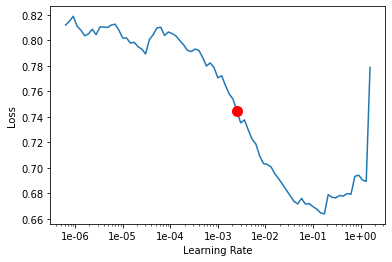

In [11]:
# tune the text_classifier_learner to accpetable accuracy (>80%)
clas_learner.lr_find()
clas_learner.recorder.plot(suggestion=True)

In [12]:
lr = clas_learner.recorder.min_grad_lr
clas_learner.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.483464,0.439143,0.789442,01:54
1,0.475224,0.383653,0.824835,01:52
2,0.449740,0.374311,0.832234,01:49
3,0.459750,0.364885,0.843031,01:39


In [13]:
clas_learner.predict("This is a horrible movie.")

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


(Category tensor(1), tensor(1), tensor([0.0987, 0.9013]))

In [14]:
clas_learner.predict("This is a great movie,")

(Category tensor(1), tensor(1), tensor([2.6069e-04, 9.9974e-01]))

In [15]:
# Check the label mapping
# suppose it returns {'negative': 0, 'positive': 1}
data_clas.train_ds.y.c2i

{'negative': 0, 'positive': 1}

In [16]:
import pandas as pd


df = pd.read_csv(path+"/test.csv")
y_true = tensor(df["sentiment"]=="positive")

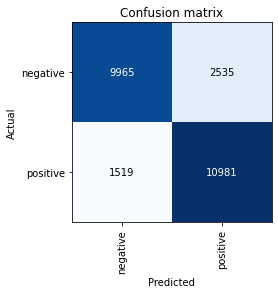

In [17]:
interp = TextClassificationInterpretation.from_learner(
    clas_learner, 
    ds_type=DatasetType.Test
)
interp.y_true = tensor(df["sentiment"]=="positive")
interp.plot_confusion_matrix()

In [18]:
from fastai.metrics import accuracy

accuracy(interp.preds, interp.y_true)

tensor(0.8378)